#  MODIS Water Clustering Analysis

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
GPU = True
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5
num_datapoints = 10000000

In [3]:
# #############################
# # VERSION 4.2.1 (targeted 500k points)
# TILE_IN = 'Golden'#v4.2.1
# DATA_VERSION='v4.2.1'
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
# #############################

# ##############################
# #VERSION 2.0.1 (5 million points)
# TILE_IN = 'GLOBAL'#v2.0.1
# DATA_VERSION='v2.0.1'
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
# ##############################

#############################
#VERSION 0.0.0 (2billion data points)
TILE_IN = 'cleaned'#v2.0.1
DATA_VERSION='AGU'
offsets_indexes = []#'x_offset', 'y_offset', 'year', 'julian_day']
##############################

training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/AGU/MOD09.Total.all.2334352265.09052022.cleaned.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/AGU/MOD09.Total.all.2334352265.09052022.cleaned.parquet.gzip


## Data Preprocessing Functions

In [4]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [5]:

def plotting_clusters(X_w,X_l,cluster_output_w,cluster_output_l,
                      n_cluster,kme_w=None,kme_l=None):
    fig = plt.figure(figsize = (25, 10))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')

    ax1 = plt.subplot(131)
    ax1.set_title(f'Land and Water Datapoints')
    ax1.scatter(X_w.values[:,0], X_w.values[:,1],label='Water')
    ax1.scatter(X_l.values[:,0], X_l.values[:,1],label='Land')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.set_xlabel(X_w.columns[0])
    ax1.set_ylabel(X_w.columns[1])
    ax1.legend(loc='lower right',fontsize="20")

    ax2 = plt.subplot(132)
    ax2.set_title(f'Water Datapoints Clustered: {len(X_water)} Examples')
    ax2.scatter(X_w.values[:,0], X_w.values[:,1],c=cluster_output_w,cmap='tab10')
    if kme_w is not None:
        ax2.scatter(kme_w.cluster_centers_[:,0],kme_w.cluster_centers_[:,1],
            label='Center Point',c='k',s=150)
        ax2.legend(loc='lower right',fontsize="20")
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='minor', labelsize=10)
    ax2.set_xlabel(X_w.columns[0])
    ax2.set_ylabel(X_w.columns[1])
    

    ax3 = plt.subplot(133)
 
    ax3.set_title(f'Land Datapoints Clustered: {len(X_land)} Examples')
    ax3.scatter(X_l.values[:,0], X_l.values[:,1],c=cluster_output_l,cmap='tab10')
    if kme_l is not None:
        ax3.scatter(kme_l.cluster_centers_[:,0],kme_l.cluster_centers_[:,1],
                    label='Center Point',c='k',s=150)
        ax3.legend(loc='lower right',fontsize="20")
    ax3.tick_params(axis='both', which='major', labelsize=10)
    ax3.tick_params(axis='both', which='minor', labelsize=10)
    ax3.set_xlabel(X_l.columns[0])
    ax3.set_ylabel(X_l.columns[1])
   

    plt.show()

In [6]:

def plotting_3d(X_w,X_l,n_cluster):
    fig = plt.figure(figsize = (15, 7))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')
    ax = plt.subplot(111,projection='3d')
    ax.set_title(f'Land and Water Datapoints')
    ax.scatter(X_w.values[:,0], X_w.values[:,1], X_w.values[:,2],label='Water')
    ax.scatter(X_l.values[:,0], X_l.values[:,1],  X_l.values[:,2], label='Land')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(X_w.columns[0])
    ax.set_ylabel(X_w.columns[1])
    ax.set_zlabel(X_w.columns[2])
    ax.legend(fontsize="10")
    plt.show()
    
    
def plotting_clusters_3d(X,kme,kmeans_output,n_cluster,axtitle):
    fig = plt.figure(figsize = (15, 7))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')
    ax = plt.subplot(111,projection='3d')
    ax.set_title(f'{axtitle}')#Land Datapoints Clustered: {len(X_land)} Examples')
    ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2], c=kmeans_output,cmap='tab10')
    # ax.scatter(kme.cluster_centers_[:,0],kme.cluster_centers_[:,1],kme.cluster_centers_[:,2],
                    # label='Center Point',c='k',s=150)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_zlabel(X.columns[2])
    ax.legend(fontsize="10")
    plt.show()

In [7]:
colsToDrop = [
            #'sur_refl_b01_1',
            # 'sur_refl_b02_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
            # 'sur_refl_b07_1',
             'ndvi',
             'ndwi1','ndwi2'
            ]

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

## Input data

In [8]:
colsToDrop

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'ndvi',
 'ndwi1',
 'ndwi2']

In [9]:
%%time
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                # imbalance=True,
                                # frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

subset data shape: (10000000, 3), (10000000,)
CPU times: user 24min 45s, sys: 8min, total: 32min 46s
Wall time: 28min 39s


In [10]:
X

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b07_1
1647137286,-48,3,53
834448758,86,251,184
2066822894,195,215,170
1958151099,319,1875,743
2241962578,415,3133,745
...,...,...,...
1345505965,31,25,3
2160733966,8,2,15
344312045,938,2379,1860
1420881883,920,3337,1135


#### separate the land and water points

In [13]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(y>0.5)[0]
y_land_ind = np.where(y<0.5)[0]

#Subset the X AND y data to later/ subset with the clusters and then combine for RFA
X_water = X.iloc[y_water_ind,:]
y_water = y.iloc[y_water_ind]

X_land = X.iloc[y_land_ind,:]
y_land = y.iloc[y_land_ind]

In [14]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b07_1


## Investigating clustering with sfc reflectance bands 1,2

### kmeans land and water together

In [ ]:
# plt.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
# plt.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
# plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_water.columns[0])
# plt.ylabel(X_water.columns[1])

In [ ]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [ ]:
%%time
kme_water =  KMeans(n_clusters=5, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)

In [ ]:
plt.scatter(X_water.values[:,0], X_water.values[:,1],
            c=kmeans_output_water,cmap='tab10',s=25)
plt.scatter(kme_water.cluster_centers_[:,0],kme_water.cluster_centers_[:,1],
            label='Center Point',c='k',s=50)
plt.title(f'Kmeans Clustering, Water Datapoints, {num_datapoints} Samples')
plt.legend()
plt.xlabel(X_water.columns[0])
plt.ylabel(X_water.columns[1])

In [ ]:
# plt.scatter(X_land.values[:,0], X_land.values[:,1],
#             c=kmeans_output_land,cmap='tab10',s=25)
# plt.scatter(kme_land.cluster_centers_[:,0],kme_land.cluster_centers_[:,1],
#             label='Center Point',c='k',s=50)
# plt.title(f'Kmeans Clustering, Land Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_land.columns[0])
# plt.ylabel(X_land.columns[1])

### kmeans land versus water analysis

In [ ]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

#### varying cluster number

##### 5

In [ ]:
CLUSTER_NUM=5

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)

##### 5 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 10

In [ ]:
CLUSTER_NUM=10

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 10 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 15

In [ ]:
CLUSTER_NUM=15

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 15 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 20

In [ ]:
CLUSTER_NUM=20

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 20 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 25

In [ ]:
CLUSTER_NUM=25

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 25 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 30

In [ ]:
CLUSTER_NUM=30

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 30 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

### Gaussian mixture model 

In [13]:
from sklearn import mixture

In [14]:
%%time
bgm_water = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit_predict(X_water)

CPU times: user 6h 18min 25s, sys: 37min 42s, total: 6h 56min 8s
Wall time: 22min 56s


In [15]:
bgm_water

array([14, 10,  0, ...,  9,  9,  9])

In [16]:
np.unique(bgm_water)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:
%%time

bgm_land = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit_predict(X_land)

CPU times: user 6h 25min 9s, sys: 38min 44s, total: 7h 3min 53s
Wall time: 25min 41s


In [18]:
bgm_land

array([12,  4, 12, ...,  6,  5,  7])

In [19]:
np.unique(bgm_land)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

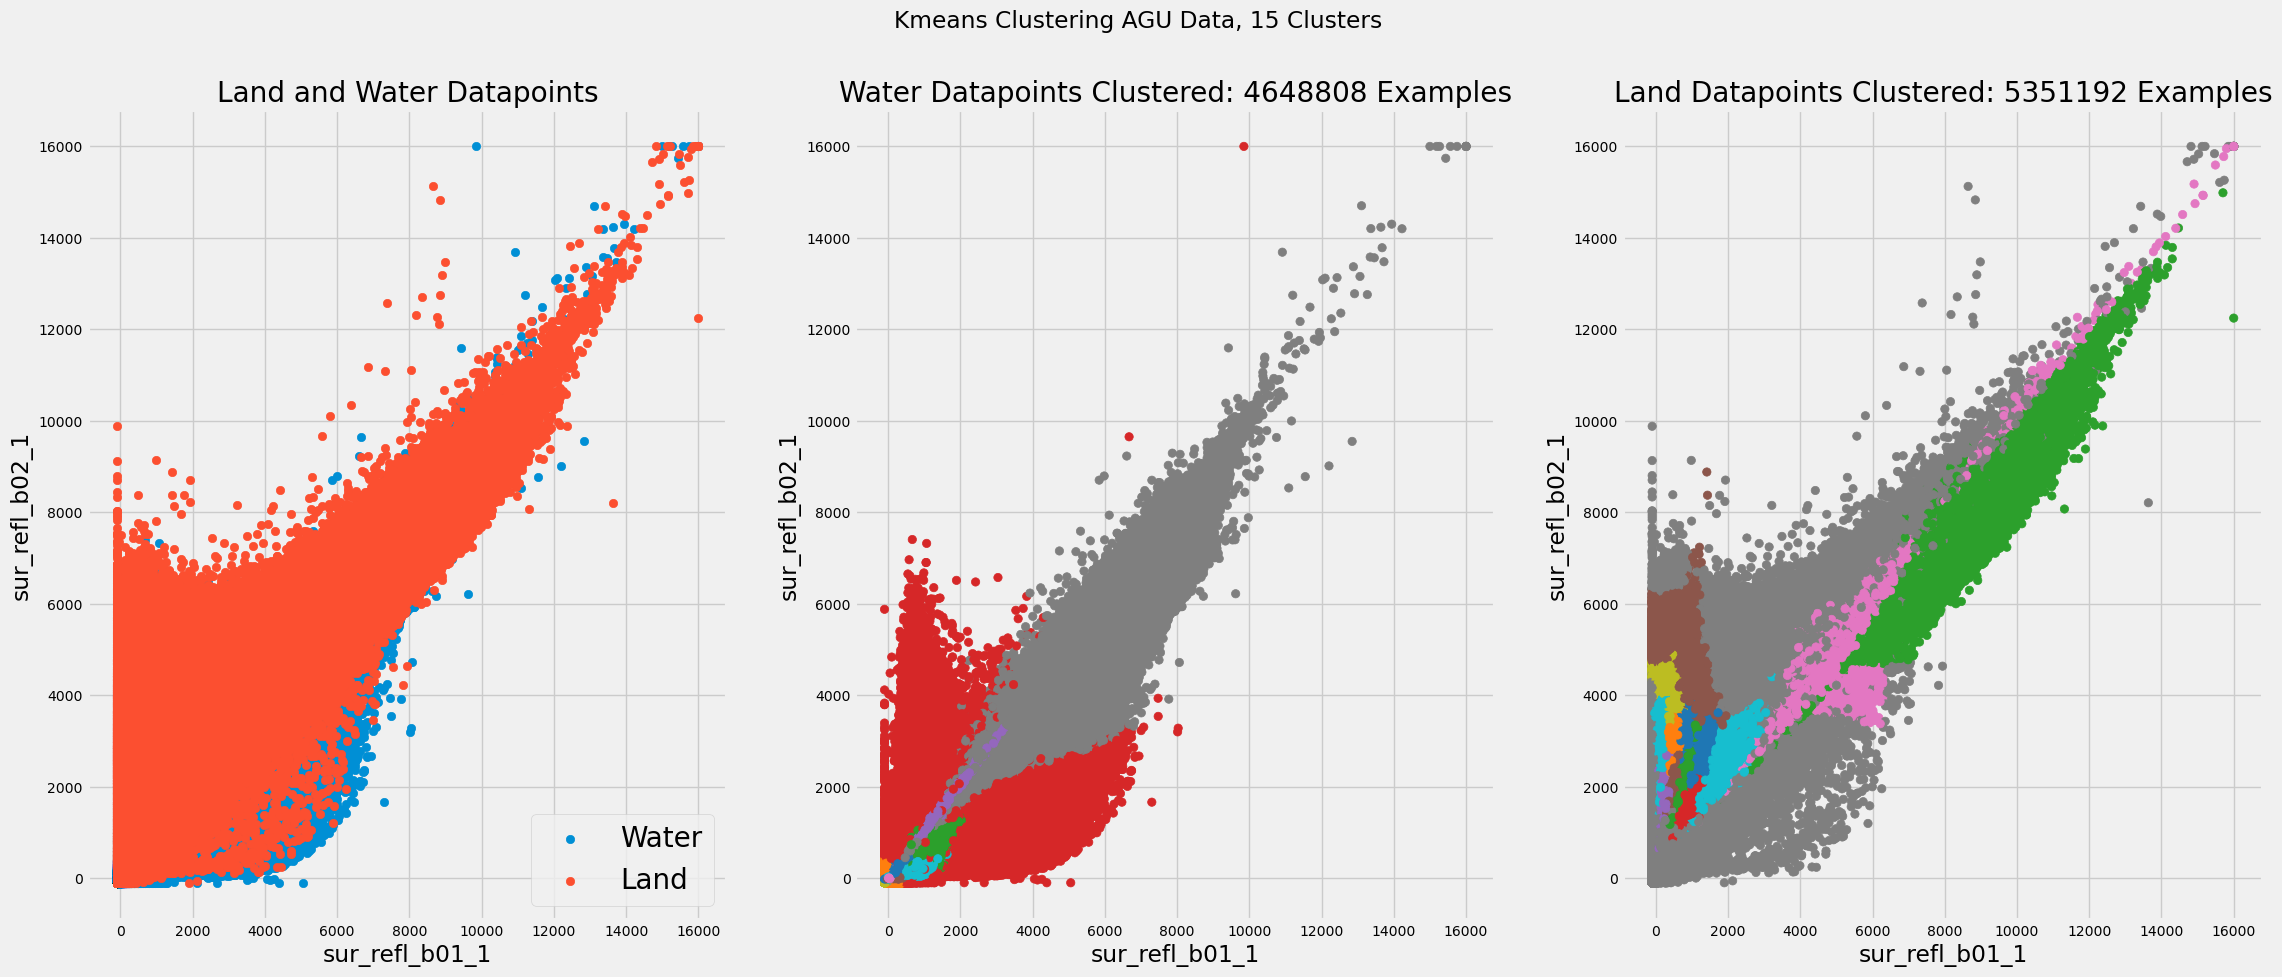

In [20]:
plotting_clusters(X_water,X_land,bgm_water,bgm_land,15)

## Adding more input bands

In [ ]:
colsToDrop = [
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [ ]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

In [ ]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind_3D = np.where(y>0.5)[0]
y_land_ind_3D = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_3D = X.iloc[y_water_ind_3D,:]
y_water_3D = y.iloc[y_water_ind_3D]

X_land_3D = X.iloc[y_land_ind_3D,:]
y_land_3D = y.iloc[y_land_ind_3D]

In [ ]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
ax.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],label='Land')
ax.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],label='Water')

ax.set_xlabel(X_land.columns[0])
ax.set_ylabel(X_land.columns[1])
ax.set_zlabel(X_land.columns[2])
plt.legend()

plt.show()

### Kmeans

In [ ]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [ ]:
%%time
kme_water_3D =  KMeans(n_clusters=5, **common_params).fit(X_water_3D)
kmeans_output_water_3D = kme_water_3D.predict(X_water_3D)

In [ ]:
%%time
kme_land_3D =  KMeans(n_clusters=5, **common_params).fit(X_land_3D)
kmeans_output_land_3D = kme_land_3D.predict(X_land_3D)

In [ ]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'Kmeans Clustering, {num_datapoints} Samples')
ax1 = plt.subplot(121,projection ="3d")
# ax1 = plt.axes(projection ="3d")
ax1.set_title(f'Water Datapoints')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

ax1.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],
           marker='o',c=kmeans_output_water_3D,cmap='tab10')
ax1.scatter(kme_water_3D.cluster_centers_[:,0],kme_water_3D.cluster_centers_[:,1],kme_water_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax1.legend()
ax1.set_xlabel(X_water_3D.columns[0])
ax1.set_ylabel(X_water_3D.columns[1])
ax1.set_zlabel(X_water_3D.columns[2])


ax2 = plt.subplot(122,projection ="3d")
# ax2 = plt.axes(projection ="3d")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=10)

ax2.set_title(f'Land Datapoints')
ax2.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],
           marker='o',c=kmeans_output_land_3D,cmap='tab10')
ax2.scatter(kme_land_3D.cluster_centers_[:,0],kme_land_3D.cluster_centers_[:,1],kme_land_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax2.legend()
ax2.set_xlabel(X_land_3D.columns[0])
ax2.set_ylabel(X_land_3D.columns[1])
ax2.set_zlabel(X_land_3D.columns[2])

plt.show()

### Birch

In [ ]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

In [ ]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Birch Clustering: {num_datapoints} Samples')
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=birch_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

## Comparing targeted and clustered samples


In [ ]:
DATA_VERSION='v4.2.1'
training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

#VERSION 4.2.1
TILE_IN = 'Golden'#v4.2.1
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)


X_target, X_test_target, y_target, y_test_target = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                trainTestSplit=True
                                )

X_target = X_target.iloc[:num_datapoints,:] 
y_target = y_target.iloc[:num_datapoints] 

X_test_target = X_test_target.iloc[:num_datapoints,:] 
y_test_target = y_test_target.iloc[:num_datapoints] 

print(f'\n\ntarget subset data shape: {X_target.shape}, {y_target.shape}')

#Getting the indices that are associated with land (0) and water (1)
#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_target = X_target.iloc[np.where(y_target>0.5)[0],:]
X_land_target = X_target.iloc[np.where(y_target<0.5)[0],:]

In [ ]:
# DATA_VERSION='v2.0.1'
# training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

# #VERSION 4.2.0
# TILE_IN = 'GLOBAL'#v4.2.0
# offsets_indexes_rand = ['x_offset', 'y_offset', 'year', 'julian_day']

# glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
# data_paths = sorted([fv for fv in glob.glob(glob_string)])

# #Only want the one with 4.2.0 because the other file doesnt work. 
# print(data_paths)
# data_path = data_paths[0]
# print(data_path)

# colsToDropTraining = colsToDrop.copy()
# colsToDropTraining.extend(offsets_indexes_rand)

# X_rand, X_test_rand, y_rand, y_test_rand = load_data(fpath=data_path,
#                                 colsToDrop=colsToDropTraining,
#                                 dataType=DATA_TYPE,
#                                 cpu=True,
#                                 splitXY=True,
#                                 trainTestSplit=True
#                                 )

# X_rand = X_rand.iloc[:num_datapoints,:] 
# y_rand = y_rand.iloc[:num_datapoints] 

# X_test_rand = X_test_rand.iloc[:num_datapoints,:] 
# y_test_rand = y_test_rand.iloc[:num_datapoints] 

# print(f'\n\nrandom subset data shape: {X_rand.shape}, {y_rand.shape}')

# #Getting the indices that are associated with land (0) and water (1)
# #Subset the X AND y data to later subset with the clusters and then combine for RFA
# X_water_rand = X_rand.iloc[np.where(y_rand>0.5)[0],:]
# X_land_rand = X_rand.iloc[np.where(y_rand<0.5)[0],:]


In [ ]:
# df.drop(df[df['Fee'] >= 24000].index, inplace = True)

In [ ]:
fig = plt.figure(figsize = (25, 10))

ax = plt.subplot(121)
ax.set_title(f'Water Datapoints')
ax.scatter(X_water_rand.values[:,0],X_water_rand.values[:,2],label=f'All Water v2.0.0')
ax.scatter(X_water_target.values[:,0],X_water_target.values[:,2],label=f'Target Water v4.2.0')
ax.legend(loc='lower right',fontsize="20")
ax.set_xlabel(X_land_rand.columns[0])
ax.set_ylabel(X_land_rand.columns[2])

ax1 = plt.subplot(122)
ax1.set_title(f'Land Datapoints')
ax1.scatter(X_land_rand.values[:,0],X_land_rand.values[:,2],label=f'All Land v2.0.0')
ax1.scatter(X_land_target.values[:,0],X_land_target.values[:,2],label=f'Target Land v4.2.0')
ax1.legend(loc='lower right',fontsize="20")
ax1.set_xlabel(X_land_rand.columns[0])
ax1.set_ylabel(X_land_rand.columns[2])

plt.show()

### Birch

In [ ]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

In [ ]:
plt.scatter(X.values[:,0], X.values[:,1],c=birch_output)
plt.title(f'Birch Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

### Spectral 

In [ ]:
%%time
spectral = SpectralClustering(
        n_clusters=5,
        #affinity="nearest_neighbors",
        random_state=42).fit_predict(X)

In [ ]:
plt.scatter(X.values[:,0], X.values[:,1],c=spectral)
plt.title(f'Spectral Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

## Clustering Data for Input to Random Forest

Based on the cluster analysis above on 5.03.23, 15 clusters appears to have the most data and exclude outliers so will use that number for selection 

### choosing the optimal number of clusters 

In [15]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
    "init":"random"
}

In [16]:
score_water = []
for c in np.arange(1, 30):
    if c%5==0: print(c)
    kme_water = KMeans(n_clusters=c,**common_params).fit(X_water)
    score_water.append(kme_water.inertia_)

5
10
15
20
25


In [17]:
score_land = []
for c in np.arange(1, 30):
    if c%5==0: print(c)
    kme_land = KMeans(n_clusters=c,**common_params).fit(X_land)
    score_land.append(kme_land.inertia_)

5
10
15
20
25


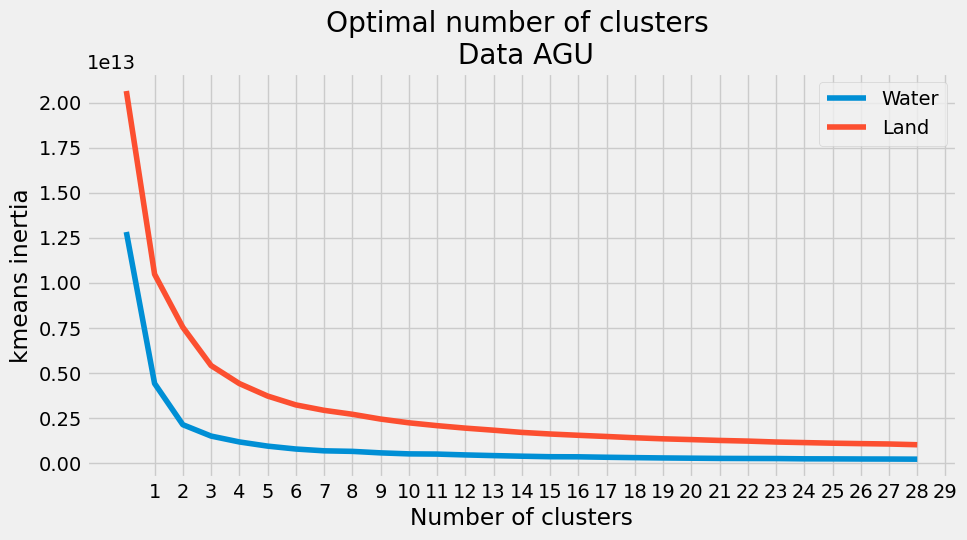

In [18]:
plt.figure(figsize = (10, 5))
plt.plot(score_water,label='Water')
plt.plot(score_land,label='Land')
plt.xticks(np.arange(1,30))
plt.xlabel("Number of clusters")
plt.ylabel("kmeans inertia")
plt.title(f"Optimal number of clusters \n Data {DATA_VERSION}")
plt.legend()

### Using the best number of clusters 

In [ ]:
CLUSTER_NUM=15

In [ ]:
%%time
kme_land_random =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land_random = kme_land_random.predict(X_land)

In [ ]:
%%time
kme_water_random = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water_random = kme_water_random.predict(X_water)

In [ ]:
# dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(X)

In [ ]:
# plotting_3d(X_water,X_land,CLUSTER_NUM)
# axtitle_water = f'Water Datapoints Clustered: {len(X_water)} Examples'
# plotting_clusters_3d(X_water,kme_water,kmeans_output_water,CLUSTER_NUM,axtitle_water)
# axtitle_land = f'Land Datapoints Clustered: {len(X_land)} Examples'
# plotting_clusters_3d(X_land,kme_land,kmeans_output_land,CLUSTER_NUM,axtitle_land)

### Random pulled datapoints

In [31]:
# List of the clusters: kmeans_output_land and kmeans_output_water
# Data: X_water, X_land, y_water, y_land

PERCENT_RANDOM_PULL = 0.15

In [32]:
np.random.seed(42)
random_ind_land = np.array([])
random_ind_water = []

for cluster in np.unique(bgm_water):
    print(f'cluster {cluster}')
    # cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    cluster_ind_water = np.where(bgm_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(PERCENT_RANDOM_PULL*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        random_ind_water = np.append(random_ind_water, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    # cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    cluster_ind_land = np.where(bgm_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(PERCENT_RANDOM_PULL*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    random_ind_land = np.append(random_ind_land, random_pts_land)
    print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
    print()
random_ind_water = random_ind_water.astype('int')
random_ind_land = random_ind_land.astype('int')

print(random_ind_water,random_ind_land)

cluster 0
Pulling 57876 Water pts and 53998 Land pts

cluster 1
Pulling 80976 Water pts and 53536 Land pts

cluster 2
Pulling 30713 Water pts and 81767 Land pts

cluster 3
Pulling 34502 Water pts and 19927 Land pts

cluster 4
Pulling 44893 Water pts and 72759 Land pts

cluster 5
Pulling 16484 Water pts and 49646 Land pts

cluster 6
Pulling 61682 Water pts and 60156 Land pts

cluster 7
Pulling 41066 Water pts and 46476 Land pts

cluster 8
Pulling 17748 Water pts and 66028 Land pts

cluster 9
Pulling 130989 Water pts and 14778 Land pts

cluster 10
Cluster 10 contains outliers
Pulling 40536 Water pts and 30726 Land pts

cluster 11
Pulling 46315 Water pts and 30038 Land pts

cluster 12
Pulling 23215 Water pts and 88313 Land pts

cluster 13
Pulling 29259 Water pts and 51389 Land pts

cluster 14
Pulling 41061 Water pts and 83136 Land pts

[3627320 2068450 4229167 ... 1523191 4111266 2237279] [2195567 2874178 4031063 ... 1114470 1909501 4192783]


#### Total random dataset used for training random forest

In [33]:
X_cluster_land_random = X_land.iloc[random_ind_land]
y_cluster_land_random = y_land.iloc[random_ind_land]
X_cluster_water_random = X_water.iloc[random_ind_water]
y_cluster_water_random = y_water.iloc[random_ind_water]

X_cluster_random = pd.concat([X_cluster_land_random,X_cluster_water_random])
y_cluster_random = pd.concat([y_cluster_land_random,y_cluster_water_random])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data_random = pd.concat([X_cluster_random,y_cluster_random],axis=1).sample(frac=1)

X_cluster_rfa_random = All_data_random[X_cluster_random.columns]
y_cluster_rfa_random = All_data_random['water']

In [34]:
print(len(X_cluster_land_random),len(X_cluster_water_random))

802673 656779


In [35]:
print(All_data_random)
print(X_cluster_rfa_random)
print(y_cluster_rfa_random)

            sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi  water
1905760264             555             528             443   -249      1
990037101               42              -4              23 -12105      1
1681817568               0             -27             316  10000      1
590801154             1744            1737            1451    -20      1
1321620282             493            1774            1365   5650      0
...                    ...             ...             ...    ...    ...
462417961              -17               4              75 -16153      1
702831883              582            3427             726   7096      0
1543389523             374            2650             777   7526      0
1475713213            1457            1473            1242     54      1
667228965               31              -6              27 -14800      1

[1459452 rows x 5 columns]
            sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi
1905760264             555    

In [36]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'v0.0.0 Land and Water Datapoints,'+ 
    f' {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land_random))} Clusters')

ax = plt.subplot(121)
#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.set_title('Water Datapoints')
ax.scatter(X_cluster_water_random .values[:,0],X_cluster_water_random.values[:,1], label=f'Cluster Water {len(y_cluster_water_random)}')
ax.scatter(X_water_target.values[:,0], X_water_target.values[:,1], label=f'Target Water {len(X_water_target)}')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(loc='lower right',fontsize="12")
ax.set_xlabel(X_cluster_water_random.columns[0])
ax.set_ylabel(X_cluster_water_random.columns[1])


ax1 = plt.subplot(122)
ax1.set_title('Land Datapoints')
ax1.scatter(X_cluster_land_random.values[:,0], X_cluster_land_random.values[:,1], label=f'Cluster Land {len(y_cluster_land_random)}')
ax1.scatter(X_land_target.values[:,0], X_land_target.values[:,1],label=f'Target Land {len(X_land_target)}')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax1.legend(loc='lower right',fontsize="12")
ax1.set_xlabel(X_cluster_water_random.columns[0])
ax1.set_ylabel(X_cluster_water_random.columns[1])

plt.show()

NameError: name 'kmeans_output_land_random' is not defined

<Figure size 1500x700 with 0 Axes>

In [ ]:
# fig = plt.figure(figsize = (15, 7))

# plt.suptitle(f'{DATA_VERSION} Land and Water Datapoints,'+ 
#     f' {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')

# ax = plt.subplot(121,projection='3d')
# #No random sample
# # ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# # ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
# #Randomly sampled data
# ax.set_title('Water Datapoints')
# ax.scatter(X_cluster_water.values[:,0], X_cluster_water.values[:,1], X_cluster_water.values[:,2],label=f'Cluster Water {len(y_random_water)}')
# ax.scatter(X_water_target.values[:,0], X_water_target.values[:,1], X_water_target.values[:,2],label=f'Target Water {len(X_water_target)}')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.legend(loc='lower right',fontsize="12")
# ax.set_xlabel(X_random_water.columns[0])
# ax.set_ylabel(X_random_water.columns[1])
# ax.set_zlabel(X_random_water.columns[2])

# ax1 = plt.subplot(122,projection='3d')
# ax1.set_title('Land Datapoints')
# ax1.scatter(X_cluster_land_random.values[:,0], X_cluster_land_random.values[:,1], X_cluster_land.values[:,2],label=f'Cluster Land {len(y_random_land)}')
# ax1.scatter(X_land_target.values[:,0], X_land_target.values[:,1], X_land_target.values[:,2],label=f'Target Land {len(X_land_target)}')
# ax1.tick_params(axis='both', which='major', labelsize=10)
# ax1.tick_params(axis='both', which='minor', labelsize=10)
# ax1.legend(loc='lower right',fontsize="12")
# ax1.set_xlabel(X_random_water.columns[0])
# ax1.set_ylabel(X_random_water.columns[1])
# ax1.set_zlabel(X_random_water.columns[2])

# plt.show()

### Distance from Centroid Cluster

In [ ]:
print(np.unique(kmeans_output_water))

In [ ]:
np.random.seed(42)
center_ind_land = np.array([])
center_ind_water = np.array([])
water_cluster_distance = kme_water.transform(X_water)
land_cluster_distance = kme_land.transform(X_land)

# DISTANCE_BOUNDS = 


for cluster in np.unique(kmeans_output_land):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water == cluster)[0]
    print(cluster_ind_water)
    clustered_water_distance = water_cluster_distance[cluster_ind_water,cluster]
    
    centroid_cluster_pts_water = np.where(clustered_water_distance < 
                    np.nanpercentile(clustered_water_distance,10))[0]
    center_ind_water = np.append(center_ind_water, centroid_cluster_pts_water)
    
#     fig = plt.figure(figsize = (25, 10))
#     ax = plt.subplot(111,projection='3d')
#     # No random sample
#     # ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}',
#     #        c=clustered_points_land) 
#     ax.scatter(X_land.values[cluster_ind_water,0], 
#                X_land.values[cluster_ind_water,1],
#                X_land.values[cluster_ind_water,2],
#                label=f'All Land {len(y_land)}',
#                alpha=0.2
#            ) 
#     ax.scatter(X_land.values[centroid_cluster_pts_water,0], 
#                X_land.values[centroid_cluster_pts_water,1],
#                X_land.values[centroid_cluster_pts_water,2],
#                label=f'Cluster',
#            ) 
#     plt.show()
    
    cluster_ind_land = np.where(kmeans_output_land == cluster)[0]
    clustered_land_distance = land_cluster_distance[cluster_ind_land,cluster]
    centroid_cluster_pts_land = np.where(clustered_land_distance < np.nanpercentile(clustered_land_distance,10))[0]
    center_ind_land = np.append(center_ind_land, centroid_cluster_pts_land)
    
        
    print(f'Pulling {len(centroid_cluster_pts_water)} Water pts and {len(centroid_cluster_pts_land)} Land pts')
    
    #https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster 
    #how to identify distance from the center 
    
center_ind_water = center_ind_water.astype('int')
center_ind_land = center_ind_land.astype('int')

print(np.shape(center_ind_land),np.shape(center_ind_water))
print(center_ind_water,center_ind_land)

In [ ]:
X_cluster_land_center = X_land.iloc[center_ind_land]
y_cluster_land_center = y_land.iloc[center_ind_land]
X_cluster_water_center = X_water.iloc[center_ind_water]
y_cluster_water_center = y_water.iloc[center_ind_water]

X_cluster_center = pd.concat([X_cluster_land_center,X_cluster_water_center])
y_cluster_center = pd.concat([y_cluster_land_center,y_cluster_water_center])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data_center = pd.concat([X_cluster_center,y_cluster_center],axis=1).sample(frac=1)

X_cluster_rfa_center = All_data_center[X_cluster_center.columns]
y_cluster_rfa_center = All_data_center['water']

In [ ]:
# clustered_points_land = np.ones(np.shape(X_land.iloc[:,0]))
# clustered_points_land[center_ind_land] = 2.0
# print(clustered_points_land[:1200])

# fig = plt.figure(figsize = (25, 10))
# ax = plt.subplot(111)
# #No random sample
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}',
#            c=clustered_points_land)
# # #Randomly sampled data
# # ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
# # ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

# # ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
# #     f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
# # ax.tick_params(axis='both', which='major', labelsize=10)
# # ax.tick_params(axis='both', which='minor', labelsize=10)
# # ax.legend(loc='lower right',fontsize="12")
# # ax.set_xlabel(X_random_water.columns[0])
# # ax.set_ylabel(X_random_water.columns[1])

# plt.show()

In [ ]:
# #No random sample
# ax.hist(X_water.values[:,0],label=f'All Water {len(y_water)}',alpha=0.8)
# ax.hist(X_land.values[:,0],label=f'All Land {len(y_land)}', alpha=0.8)
# ax.hist(X_random_water.values[:,0],label=f'Samp Water {len(y_random_water)}', alpha=0.8)
# ax.hist(X_random_land.values[:,0], label=f'Samp Land {len(y_random_land)}',alpha=0.8) 
# # ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
# # #Randomly sampled data
# # ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
# # ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

# ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
#     f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.legend(loc='lower right',fontsize="12")
# ax.set_xlabel(X_random_water.columns[0])
# # ax.set_ylabel(X_random_water.columns[1])

# plt.show()

In [ ]:
y_cluster_water_random 
y_cluster_water_center

In [ ]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'{DATA_VERSION} Land and Water Datapoints,'+ 
    f' {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')

ax = plt.subplot(121)
#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.set_title('Water Datapoints')
ax.scatter(X_cluster_water_random.values[:,0], X_cluster_water_random.values[:,1],label=f'Cluster Water Random {len(y_cluster_water_random )}')
ax.scatter(X_cluster_water_center.values[:,0], X_cluster_water_center.values[:,1],label=f'Cluster Water Centered {len(y_cluster_water_center)}')
ax.legend(loc='lower right',fontsize="12")
           
    
ax = plt.subplot(122)
#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.set_title('Land Datapoints')
ax.scatter(X_cluster_land_random.values[:,0], X_cluster_land_random.values[:,1],label=f'Cluster Land Random {len(y_cluster_land_random )}')
ax.scatter(X_cluster_land_center.values[:,0], X_cluster_land_center.values[:,1],label=f'Cluster Land Centered {len(y_cluster_land_center)}')
ax.legend(loc='lower right',fontsize="12")
           
plt.show()

https://medium.com/@prasadostwal/multi-dimension-plots-in-python-from-2d-to-6d-9a2bf7b8cc74 for adding in more dimensions for plotting

## Random forest

In [37]:
import optuna
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.inspection import permutation_importance


#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal
from pprint import pprint

In [38]:
FIGURE_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'


TILE = 'h11v02'
DAY = 233
YEAR = 2006

# TILE = 'h21v10'
# DAY = 100
# YEAR = 2019

FRAC_LAND = 0.5

##Add in the other stuff for tuning
frac_water = int(100*(1.0-FRAC_LAND))
if len(colsToDrop) >= 1:
    save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_no-vars_{'-'.join(colsToDrop)}"
else: 
     save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_all-vars"

print(save_file)

h11v02_233_2006_frac-water50_no-vars_sur_refl_b03_1-sur_refl_b04_1-sur_refl_b05_1-sur_refl_b06_1-ndwi1-ndwi2


#### RF FUNCTIONS

In [39]:
def rf_objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    # if TREES_AND_DEPTH_ONLY:
    #     param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
    #                'criterion':'gini', 
    #                'max_depth':trial.suggest_categorical('max_depth', max_depth), 
    #                'min_samples_split':2, 
    #                'min_samples_leaf':1, 
    #                'min_weight_fraction_leaf':0.0, 
    #                'max_features':'auto', 
    #                'max_leaf_nodes':None, 
    #                'min_impurity_decrease':0.0, 
    #                'bootstrap':True, 
    #                'oob_score':False, 
    #                'n_jobs':-1, 
    #                # 'random_state':42, 
    #                'verbose':0, 
    #                'warm_start':True, 
    #                'class_weight':None, 
    #                'ccp_alpha':0.0, 
    #                'max_samples':None
    #                   }
    # else:
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #######################
    # HERE IS WHERE TO CHANGE THE X,Y DATASET USED FOR TRAINING
    #######################
   
    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X_cluster_rfa_random,  y_cluster_rfa_random)):
        X_train, X_val = X_cluster_rfa_random.iloc[train_idx], X_cluster_rfa_random.iloc[val_idx]
        y_train, y_val = y_cluster_rfa_random.iloc[train_idx],  y_cluster_rfa_random.iloc[val_idx]
        
    # for idx, (train_idx, val_idx) in enumerate(cv.split(X_cluster_rfa_center, y_cluster_rfa_center)):
    #     X_train, X_val = X_cluster_rfa_center.iloc[train_idx], X_cluster_rfa_center.iloc[val_idx]
    #     y_train, y_val = y_cluster_rfa_center.iloc[train_idx], y_cluster_rfa_center.iloc[val_idx]

        model = skRF(**param)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5,10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'],
    
}

In [40]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'): os.remove('tmp.vrt')
    
    return img

In [41]:
def predictRaster(img_chunk, classifier, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [42]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 


# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

#### Training RF

In [43]:
TREES_AND_DEPTH_ONLY = False
GRID_SEARCH = True

In [44]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')
#Objective is under the functions area

#####################################################################
#CHANGE HERE FOR DIFFERENT MODELING TYPE
#rf_objective or xgb_objective
#####################################################################

study.optimize(rf_objective, n_trials=25, timeout=30*60)

[I 2023-05-15 14:09:03,702] A new study created in memory with name: RF Tuning Grid Search


Fold 0: 0.9852137832594972
Fold 1: 0.9860000151926043
Fold 2: 0.9854921729096127
Fold 3: 0.986121711263247


[I 2023-05-15 14:09:54,521] Trial 0 finished with value: 0.9857333380204599 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 0 with value: 0.9857333380204599.


Fold 4: 0.9858390074773381
Fold 0: 0.9870102263151103
Fold 1: 0.9876615389287937
Fold 2: 0.9873203462710585
Fold 3: 0.987594785785075


[I 2023-05-15 14:11:33,907] Trial 1 finished with value: 0.9874331903518708 and parameters: {'n_estimators': 175, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9875790544593169
Fold 0: 0.985228704589273
Fold 1: 0.9861350964622293
Fold 2: 0.9855383821207336
Fold 3: 0.986186345777896


[I 2023-05-15 14:11:58,040] Trial 2 finished with value: 0.985800740216231 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.985915172131023
Fold 0: 0.9869109649605506
Fold 1: 0.9875421335519723
Fold 2: 0.9871268083362738
Fold 3: 0.9874874722871807


[I 2023-05-15 14:14:37,041] Trial 3 finished with value: 0.9873251280961618 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9875582613448312
Fold 0: 0.9866307216220834
Fold 1: 0.9871611332834613
Fold 2: 0.9868818608323338
Fold 3: 0.9871806555484675


[I 2023-05-15 14:20:29,271] Trial 4 finished with value: 0.986984657539144 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9870689164093742
Fold 0: 0.9867953468594338
Fold 1: 0.9874286668919459
Fold 2: 0.9870839674954739
Fold 3: 0.9873093748101343


[I 2023-05-15 14:23:31,167] Trial 5 finished with value: 0.987182327620836 and parameters: {'n_estimators': 250, 'max_depth': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9872942820471927
Fold 0: 0.9866844864965428
Fold 1: 0.9871853772814775
Fold 2: 0.9869805505367202
Fold 3: 0.9871882499468392


[I 2023-05-15 14:26:01,626] Trial 6 finished with value: 0.9870398619977641 and parameters: {'n_estimators': 200, 'max_depth': 110, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9871606457272406
Fold 0: 0.9867885561562292
Fold 1: 0.987413670689989
Fold 2: 0.987080809460916
Fold 3: 0.9872907260652133


[I 2023-05-15 14:27:22,128] Trial 7 finished with value: 0.9871729555979861 and parameters: {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9872910156175838
Fold 0: 0.985953690479808
Fold 1: 0.9865424863164852
Fold 2: 0.9862755743188091
Fold 3: 0.9865193890612952


[I 2023-05-15 14:30:27,423] Trial 8 finished with value: 0.9863692737186301 and parameters: {'n_estimators': 250, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9865552284167538
Fold 0: 0.9868985023063344
Fold 1: 0.9873946389247475
Fold 2: 0.9870616856623438
Fold 3: 0.9874015628441029


[I 2023-05-15 14:31:31,485] Trial 9 finished with value: 0.9872295516926224 and parameters: {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9873913687255829
Fold 0: 0.9870355677206516
Fold 1: 0.9876648202495891
Fold 2: 0.9872740315093916
Fold 3: 0.9874545302663255


[I 2023-05-15 14:33:16,173] Trial 10 finished with value: 0.9873977574840502 and parameters: {'n_estimators': 175, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9875598376742932
Fold 0: 0.9852082463267398
Fold 1: 0.9860731425794301
Fold 2: 0.9858097620032562
Fold 3: 0.9861574743941758


[I 2023-05-15 14:33:46,101] Trial 11 finished with value: 0.9858037041352128 and parameters: {'n_estimators': 125, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9857698953724626
Fold 0: 0.9857237286976606
Fold 1: 0.9861902066340196
Fold 2: 0.9859068278399964
Fold 3: 0.9861630345582202


[I 2023-05-15 14:35:25,868] Trial 12 finished with value: 0.9860222642328322 and parameters: {'n_estimators': 125, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9861275234342644
Fold 0: 0.9866896478413388
Fold 1: 0.9873448481419745
Fold 2: 0.9870192964610504
Fold 3: 0.9872152672567314


[I 2023-05-15 14:37:53,983] Trial 13 finished with value: 0.9870868857963041 and parameters: {'n_estimators': 200, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9871653692804253
Fold 0: 0.9870173254171917
Fold 1: 0.9876536647962398
Fold 2: 0.9873090089337898
Fold 3: 0.9875266269493206


[I 2023-05-15 14:38:57,632] Trial 14 finished with value: 0.9874163863178291 and parameters: {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9875753054926032
Fold 0: 0.9870019436345968
Fold 1: 0.9876142887518604
Fold 2: 0.9872668273336244
Fold 3: 0.9874508761604618


[I 2023-05-15 14:40:55,688] Trial 15 finished with value: 0.9873686664614487 and parameters: {'n_estimators': 200, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 1 with value: 0.9874331903518708.


Fold 4: 0.9875093964267003
CPU times: user 18h 52min 41s, sys: 1min 55s, total: 18h 54min 37s
Wall time: 31min 51s


In [63]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)

Number of finished trials: 16
{'n_estimators': 175, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}


In [46]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
print(hyperparameters)

tuned_classifier = skRF(**hyperparameters)


Using these params:
{'n_estimators': 175, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2', 'n_jobs': -1}


In [47]:
%%time 
tuned_classifier.fit(X_cluster_rfa_random , y_cluster_rfa_random)

CPU times: user 16min 43s, sys: 1.75 s, total: 16min 44s
Wall time: 28.6 s


RandomForestClassifier(max_depth=50, max_features='log2', min_samples_leaf=5,
                       n_estimators=175, n_jobs=-1)

Saving output cluster model

In [48]:
import pickle
# save the model to disk
filename = 'MODIS_RFA_v000_15Cluster_bgm_sfcref127_ndvi.pkl'
pickle.dump(tuned_classifier, open(filename, 'wb'))

## Image Testing with Random Forest

In [49]:
import sys
sys.path.append('../../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [50]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)


#######
#in the TabularModisDataGenerator on line ~270 I commented out the line that would write out the qa mask
#qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006233.h11v02*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf
Julian day: 233
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [51]:
vars_list_gq = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list


#IMPORTANT FOR QGIS POTENTIALLY BECAUSE OF LIST OF MODIS DATA

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006233.h11v02.061.2020270015518.hdf":MODIS_Grid_500m_2D:sur_r

#### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [52]:
%%time

im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[-28672 -28672 -28672 ...      0      0      0]
 [-28672 -28672 -28672 ...      0      0      0]
 [-28672 -28672 -28672 ...      0      0      0]
 ...
 [   326   1737    178 ...   6839    897   4846]
 [   302   1661    174 ...   6923    827   4810]
 [   332   1845    174 ...   6949   1346   5203]]
460.8 MB size
CPU times: user 6.56 s, sys: 928 ms, total: 7.49 s
Wall time: 11.9 s


In [53]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, tuned_classifier, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 10min 53s, sys: 50.7 s, total: 11min 44s
Wall time: 31.4 s


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [54]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
predictedWaterMask = matrix.reshape(shp)
predictedWaterMask.shape

(4800, 4800)

#### Import the QA Mask and the Water Mask for the GIVEN TILE

In [55]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(water_list)
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

['/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v02_2006_v5.tif']
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v02*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v02_2006_v5.tif


#### Mask out results if QA Mask says pixel is "bad"

In [56]:
maskedResult = np.where(qa_mask == 0, predictedWaterMask, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
# # waterMaskRavel = waterMasked.ravel()
# imWater = (waterMaskRavel == 1)

In [57]:
# plt.matshow(predictedWaterMask)
# plt.matshow(maskedResult-waterMasked)
# plt.matshow(waterMasked-maskedResult)
# plt.matshow(waterMaskMatrix)

# plt.matshow(waterMasked)
# plt.matshow(maskedResult)

## Output predicted raster to GeoTiff

In [58]:
#outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_65water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
# outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_75water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_xgb.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))


print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

2006_233_h11v02_predicted_rf_xgb.tif
waterMask_2006_qa_233.tif
2006_233_h11v02_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, 7783653.637667, 0.0, -231.65635826395845)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


## Folium Viewing

In [59]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 4532.26, 0.00,-20037508.33|
| 0.00,-4532.26, 11068715.66|
| 0.00, 0.00, 1.00|
Width: 8842 Height: 589
Transform: | 4532.25, 0.00,-20037508.33|
| 0.00,-4532.25, 11068740.93|
| 0.00, 0.00, 1.00|
Width: 8842 Height: 589
Transform: | 3308.69, 0.00,-20037508.26|
| 0.00,-3308.71, 11068715.66|
| 0.00, 0.00, 1.00|
Width: 12112 Height: 2286


In [60]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)


# folium.Marker(location=[-16.4835, -72.9978]).add_to(m)

In [61]:
from folium import plugins


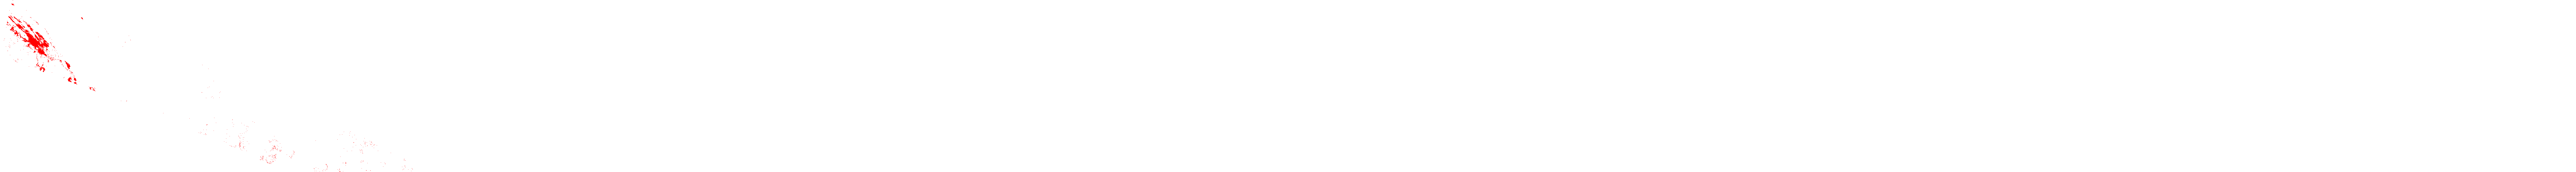
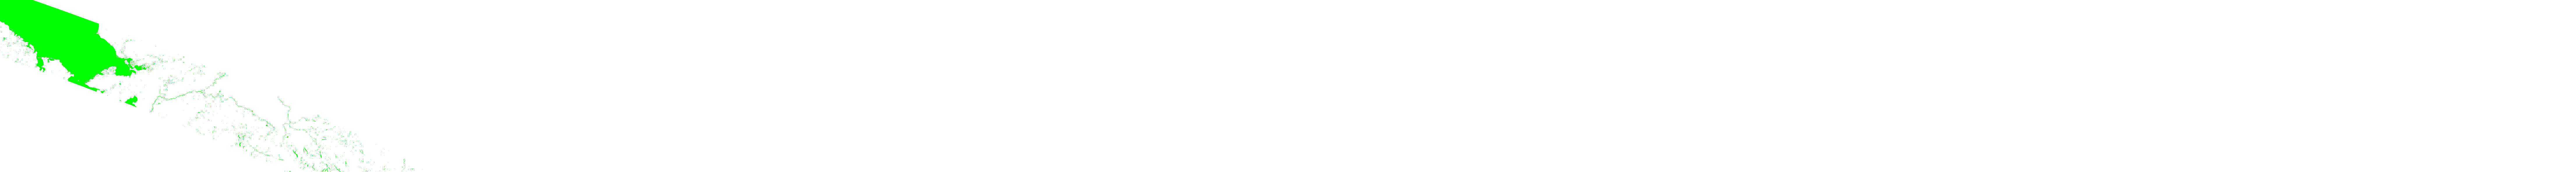
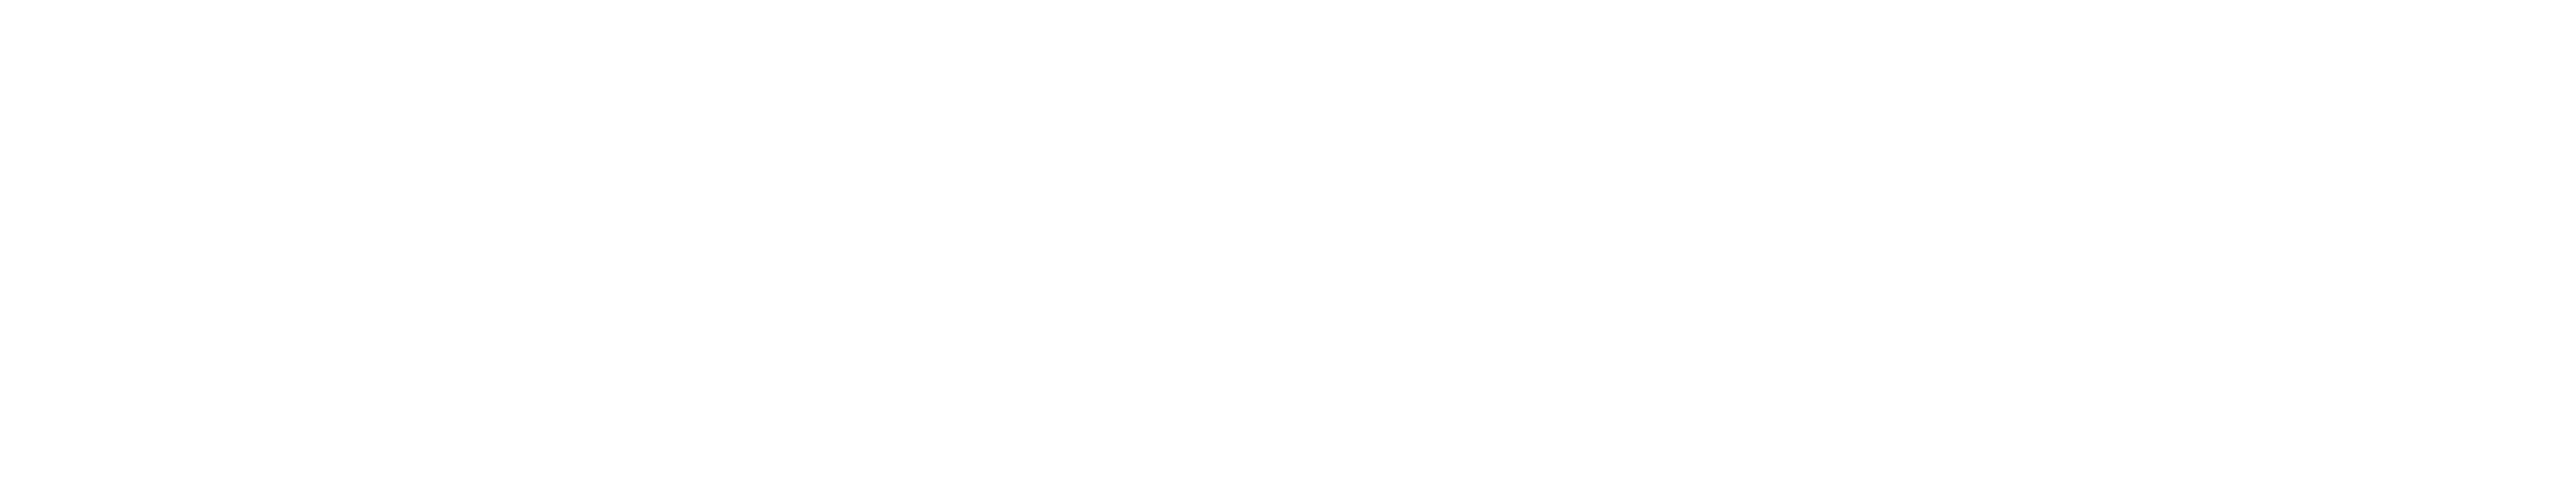

In [62]:

m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())

m